In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
import seaborn as sns

            MODEL : my_model
Non-zero Interactions (J) : 28 / 28
Non-zero Bias (h) : 8 / 8
---------------------------------------------
Average Interaction Strength <|J|> :  0.6575625
Average Bias Strength <|h|>:  0.29375
alpha :  0.5999094654953647
---------------------------------------------


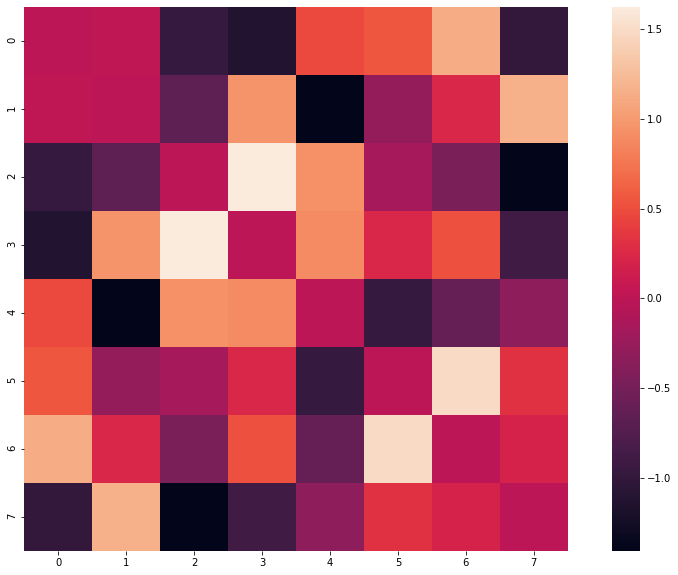

In [2]:
# define the model
np.random.seed(206147358) ##l lucky-seed: 610358
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

model.model_summary()
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
esm = Exact_Sampling(model, beta)
# esm.run_exact_sampling(beta)

     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 9
Entropy : 2.6081671598542435
---------------------------------------------


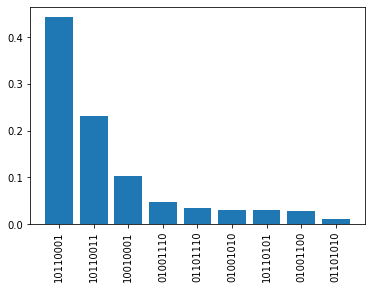

In [3]:
esm.sampling_summary()

In [4]:
# steps = 10000
# cl_chain =classical_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta,
# )
# steps = 1000
# qamcmc_chain =quantum_enhanced_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta,
#     verbose = False
# )

#### HELPER FUNCTIONS

In [4]:
int_to_binary = lambda state_obtained, n_spins : f"{state_obtained:0{n_spins}b}"
binary_to_bipolar = lambda string : 2.0 * float(string) - 1.0

def get_observable_expectation(observable: callable, mcmc_chain: MCMCChain, skip_init:int= 100) :

    sample_observable = []
    for s in mcmc_chain.accepted_states :

        sample_observable.append(observable(s) )
    
    sample_observable = np.array(sample_observable)
        
    return sample_observable.mean(dtype= float)#, sample_observable.var(dtype= float)


def correlation_spins(state: str, indices : Union[tuple, List] ):

    assert len(indices) <= len(state)
    
    
    prod = 1.0
    for _ in indices :
        prod *= binary_to_bipolar(state[_])

    return prod

def cd_J(index, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert len(index) == 2
    observable = lambda s: correlation_spins(s, [index[0], index[1]])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

def cd_h(index:int, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert isinstance(index, int)
    observable = lambda s: correlation_spins(s, [index])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

#### Class for Training

In [12]:
# @dataclass
class cd_training():
    ''' 
    model: initial model = (J init, h init) at some temp T
    beta: 1/Temperature
    data_dist: empirical data which we want to learn!
    
    '''

    def __init__(self, model: IsingEnergyFunction, beta:float ,data_dist: DiscreteProbabilityDistribution) -> None:
        self.model = model
        self.model_beta = beta
        self.data_distribution = data_dist
        self.training_history = {}
        pass

    def cd_J(self, index, mcmc_chain: MCMCChain):

        assert len(index) == 2
        observable = lambda s: correlation_spins(s, [index[0], index[1]])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    def cd_h(self, index:int, mcmc_chain: MCMCChain):

        assert isinstance(index, int)
        observable = lambda s: correlation_spins(s, [index])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    # @setattr
    # def data_distribution()
    
    def _train_on_mcmc_chain(self, lr:float= 0.01, 
    method = 'quantum-enhanced', 
    iterations: int = 100, 
    mcmc_steps:int =1000 ):# we will try to increase mcmc steps. 

        if method == 'quantum-enhanced' :
            self.mcmc_chain = quantum_enhanced_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        elif method == 'classical-uniform' : 
            self.mcmc_chain = classical_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        
        ## random update strategy ##
        for _ in range(iterations):
            
            ## update J ##
            index = [np.random.randint(0, self.model.num_spins), np.random.randint(0, self.model.num_spins)]

            updated_param_j = model.J[index[0], index[1]] + lr * self.cd_J(index, self.mcmc_chain) 
            
            self.model._update_J(updated_param_j, index)

            ## update h ##
            index = np.random.randint(0, self.model.num_spins)

            updated_param_h = model.h[index] + lr * self.cd_h(index, self.mcmc_chain) 
            
            self.model._update_h(updated_param_h, index)

            

    def train(self, lr:float= 0.01, method = 'quantum-enhanced', 
    epochs:int = 10, iterations: int = 100, 
    mcmc_steps:int = 500, show_kldiv:bool = True ):

        ## random update strategy ##
        kl_div = []
        iterator = tqdm(range(epochs), desc= 'training epochs'  )
        iterator.set_postfix({'method': method})
        for epoch in iterator:

            self._train_on_mcmc_chain(lr= lr , 
            method = method, iterations= iterations, 
            mcmc_steps= mcmc_steps )

            if show_kldiv:

                
                kl_div.append(kl_divergence(  self.mcmc_chain.get_accepted_dict(normalize= True), self.data_distribution ))
                iterator.set_postfix( { 'method ': method, 'kl div ' : kl_div[-1] })
        
        if show_kldiv : self.training_history['kl_div']= kl_div


#### TRIALS

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 8
Entropy : 2.5922074618286293
---------------------------------------------


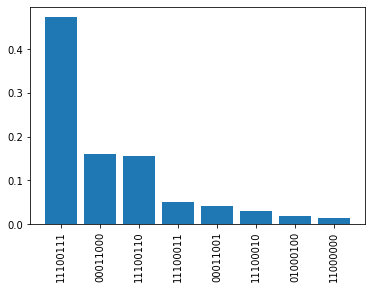

In [13]:
## INITIALISE ANOTHER RANDOM MODEL ##

np.random.seed(3)# should always be in the same cell!  
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -3, high= 3, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.4 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
beta_train = 1.001

param_model = IsingEnergyFunction(J, h, name= 'param_model')
param_model_esm = Exact_Sampling(param_model, beta= beta_train)

param_model_esm.sampling_summary()

     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 9
Entropy : 2.6081671598542435
---------------------------------------------


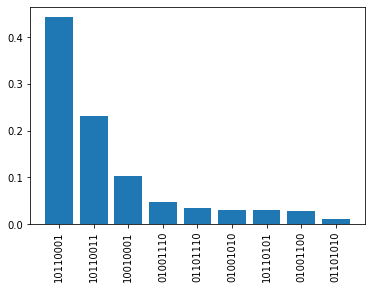

In [14]:
## COMPARE WITH THE DATA-DISTRIBUTION ##
esm.sampling_summary()

#### TRAINING

In [15]:
training_quantum = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum.train(lr = 0.01 ,method = 'quantum-enhanced' , epochs= 6, iterations= 100, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 6/6 [01:32<00:00, 15.46s/it, method =quantum-enhanced, kl div =0.133]


In [16]:
training_cl = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_cl.train(lr = 0.06 ,method = 'classical-uniform' , epochs= 6, iterations= 100, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s, method =classical-uniform, kl div =2.05]


##### Compare reconstructed model

In [17]:
classical_reconstructed_model_esm = Exact_Sampling(training_cl.model, beta= beta_train)
quantum_reconstructed_model_esm = Exact_Sampling(training_quantum.model, beta= beta_train)

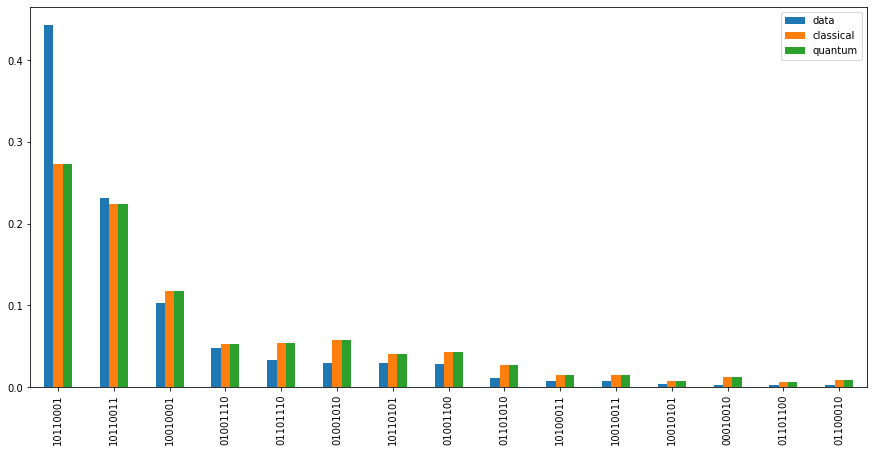

In [19]:
plot_multiple_bargraphs([esm.boltzmann_pd, classical_reconstructed_model_esm.boltzmann_pd, quantum_reconstructed_model_esm.boltzmann_pd], ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 15)

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 14
Entropy : 3.973050365751494
---------------------------------------------


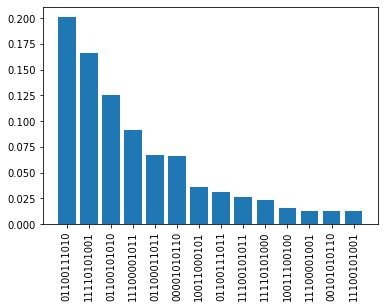

In [14]:
classical_reconstructed_model_esm.sampling_summary()

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 14
Entropy : 3.973050365751494
---------------------------------------------


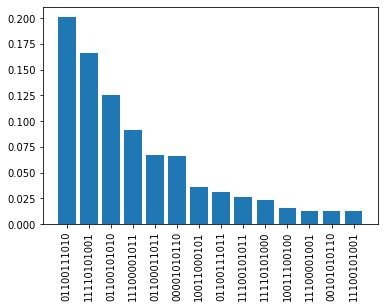

In [15]:
quantum_reconstructed_model_esm.sampling_summary()

In [16]:
training_quantum.mcmc_chain.get_accepted_dict(norma)

NameError: name 'norma' is not defined